In [66]:
using DrWatson
@quickactivate projectdir()

In [67]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase

In [68]:
function scale_embeddings(X)
    return (X .- mean(eachrow(X))') * (X'X)^(-0.5)
end

function diagram(X, dim_max; alpha=false)
    points = tuple.(eachcol(X)...)
    if alpha
        dgm = ripserer(Alpha(points), dim_max=dim_max)
    else
        dgm = ripserer(points, dim_max=dim_max)
    end
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    return [Bottleneck()(DX[d], DY[d]) for d in 1:dim_max+1]
end

function subsample(X, a=0.5)
    sample(X |> rdpg.m2t, round(Int, size(X, 1)^a ), replace=false )
end

subsample (generic function with 2 methods)

In [69]:
function generate_sbm_sparse(n, k, p, r)
    f = (x, y) -> (r + p * (x == y)) * 10 * log(n) / n
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function generate_sbm_dense(n, k, p, r)
    f = (x, y) -> (r + p * (x == y))
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function simulate_one(A, D, d, ϵ; a=false)
    A_private = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)) ./ rdpg.σ(ϵ)^2
    X_private, _, _ = rdpg.spectralEmbed(A_private, d=2, scale=false)
    D_private = diagram(X_private, d; alpha=a)
    return Bottleneck()(D[1], D_private[1])
end

simulate_one (generic function with 1 method)

## Illustration of differentially-private community detection using *persistent homology*

In [70]:
# p, r = 0.8, 0.2
p, r = 0.8, 0.1
clust = 3
n = 900
ϵ = 1
theme(:dao)

In [71]:
f = (x, y) -> ((r + p * (x == y)))
Z = rand(1:clust, 900)
A = rdpg.Adjacency(f, Z)

900×900 SparseArrays.SparseMatrixCSC{Int64, Int64} with 296394 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

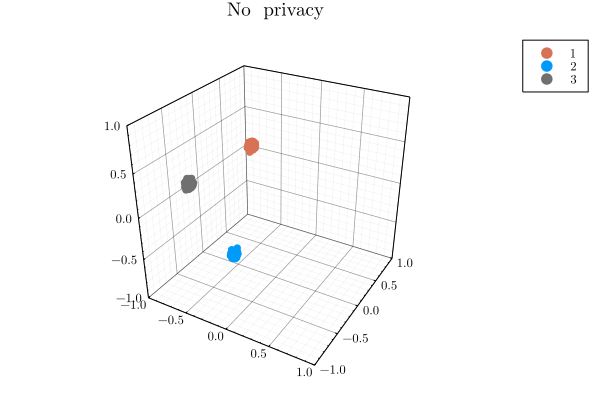

In [72]:
X, _, _ = rdpg.spectralEmbed(A, d=3, scale=false)
plt = @pipe [tuple(x...) for x in eachrow(X)]  |> scatter(_, groups=Z, lim = (-1,1), title="No  privacy")

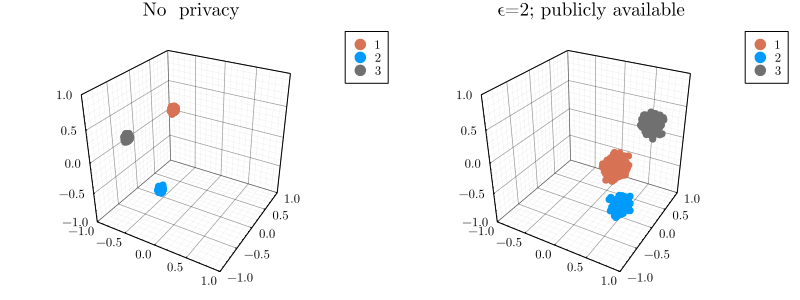

In [73]:
A_private = rdpg.edgeFlip(A, ϵ=ϵ)

A_with_eps = (A_private .- rdpg.privacy(ϵ=ϵ)) ./ (1 - 2 * rdpg.privacy(ϵ=ϵ))
X_with_eps, _ = rdpg.spectralEmbed(A_with_eps, d=3, scale=false)
plt_with_eps = @pipe [tuple(x...) for x in eachrow(X_with_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly available", lim=(-1, 1))

plot(plt, plt_with_eps, layout=(1, 2), size=(800,300))

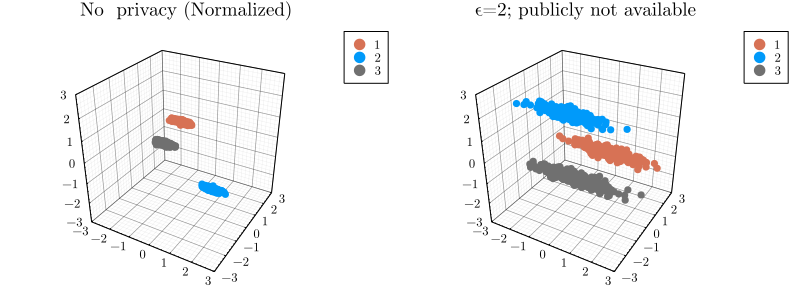

In [74]:
plt_standardized = @pipe [tuple(x...) for x in eachrow(StatsBase.standardize(ZScoreTransform, X, dims=1))] |> scatter(_, groups=Z, lim=(-3, 3), title="No  privacy (Normalized)")

X_without_eps, _ = rdpg.spectralEmbed(A_private, d=3, scale=false)
X_without_eps = StatsBase.standardize(ZScoreTransform, X_without_eps, dims=1)



plt_without_eps = @pipe [tuple(x...) for x in eachrow(X_without_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly not available", lim=(-3, 3))

plot(plt_standardized, plt_without_eps, layout=(1, 2), size=(800, 300))

## Comparison with [Seif at al. (2022)](https://arxiv.org/abs/2202.00636)

In the following, for a stochastic blockmodel with $C=3$ clusters, we examine the bottleneck distance as a function of the number of vertices $n$ when $\epsilon_n \asymp \log^k(n)$ for $k \in \{\frac 23, \frac 34, 1\}$. The result in [Seif at al. (2022)](https://arxiv.org/abs/2202.00636) requires that $\epsilon_n \gtrsim \log(n)$. 

For more information on differentially-private community detection using persistence diagrams, please see [the clustering Jupyter notebook](./clustering.ipynb).

In [83]:
repeats = 5

Ks = [1 / 2, 1]
Ks_legend = ["0.50", "1.00"]

# Ks = [1 / 2, 3 / 4, 1]
# Ks_legend = ["0.50", "0.75", "1.00"]

N = [100, 500, 1_000, 2_000, 5_000, 10_000];

In [84]:
p, r = 0.8, 0.1
clust = 3
n = length(N);

### Dense Regime

$$
\mathbb{E}(\mathbf{A}_{ij}) = \Theta(1)
$$

In [ ]:
results_dense = [zeros(repeats, n) for _ in eachindex(Ks)];


prog = Progress(convert(Int, n * repeats * length(Ks)))

Random.seed!(2022)
for i in 1:n
    
    A = generate_sbm_dense(N[i], clust, p, r)
    X, _, _ = rdpg.spectralEmbed(A, d=3, scale=false)
    DX = ripserer(X |> rdpg.m2t, dim_max=0)[1]

    for j in 1:repeats, k in eachindex(Ks)

        ϵn = 1 * log(N[i])^(Ks[k])

        A_private = (rdpg.edgeFlip(A, ϵ=ϵn) .- rdpg.τ(ϵn)) ./ rdpg.σ(ϵn)^2
        X_private, _ = rdpg.spectralEmbed(A_private, d=3, scale=false)
        D_private = ripserer(X_private |> rdpg.m2t, dim_max=0)[1]

        results_dense[k][j, i] = Bottleneck()(DX, D_private)

        next!(prog)
    end
end

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:04:07

In [ ]:
theme(:default)

plt_dense = plot(title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")

for k in eachindex(Ks)
    plot!(
        plt_dense, N,
        map(x -> x == Inf ? missing : x, results_dense[k]) |> eachcol .|> skipmissing .|> median,
        #ribbon=map(x -> x == Inf ? missing : x, results_dense[k]) |> eachcol .|> skipmissing .|> std, fa=0.1,
        marker=:o,
        label="k=$(Ks_legend[k])",
        lw=3, ylim=(0, 0.25),
        yformatter=identity
    )
end

plt_dense

In [ ]:
savefig(plotsdir("comparisons/dense.svg"))

### Sparse Regime

$$
\mathbb{E}(\mathbf{A}_{ij}) = \Theta\left(\frac{\log n}{n}\right)
$$

In [ ]:
results_sparse = [zeros(repeats, n) for _ in eachindex(Ks)];

prog = Progress(convert(Int, n * repeats * length(Ks)))

Random.seed!(2022)
for i in 1:n
    
    A = generate_sbm_sparse(N[i], clust, p, r)
    X, _, _ = rdpg.spectralEmbed(A, d=3, scale=false)
    DX = ripserer(X |> subsample, dim_max=0)[1]
    
    for j in 1:repeats, k in eachindex(Ks)

        ϵn = 1 * log(N[i])^(Ks[k])

        A_private = (rdpg.edgeFlip(A, ϵ=ϵn) .- rdpg.τ(ϵn)) ./ rdpg.σ(ϵn)^2
        X_private, _ = rdpg.spectralEmbed(A_private, d=3, scale=false)
        D_private = ripserer(X_private |> subsample, dim_max=0)[1]

        results_sparse[k][j, i] = Bottleneck()(DX, D_private)
        next!(prog)
    end
end

In [ ]:
theme(:default)

plt_sparse = plot(title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")

for k in eachindex(Ks)
    plot!(
        plt_sparse, N,
        map(x -> x == Inf ? missing : x, results_sparse[k]) |> eachcol .|> skipmissing .|> median,
        #ribbon=map(x -> x == Inf ? missing : x, results_sparse[k]) |> eachcol .|> skipmissing .|> std, fa=0.1,
        marker=:o,
        label="k=$(Ks_legend[k])",
        lw=3, ylim=(0, 0.25),
        yformatter=identity
    )
end

plt_sparse

In [ ]:
savefig(plotsdir("comparisons/sparse.svg"))